In [1]:
!ls ../experiments/multimodalmodel_wavlmlarge_robertalarge_lazyload_lr1e4_focalloss/results/dev.csv

../experiments/multimodalmodel_wavlmlarge_robertalarge_lazyload_lr1e4_focalloss/results/dev.csv


In [2]:
def get_stratified_subset(df, label_column, num_examples_per_label, random_state=None):
    """
    Returns a stratified subset of the dataframe with a fixed number of examples for each label.

    Args:
        df (pd.DataFrame): The input dataframe.
        label_column (str): The name of the column containing the labels.
        num_examples_per_label (int): The fixed number of examples to sample for each label.
        random_state (int, optional): Random seed for reproducibility.

    Returns:
        pd.DataFrame: A stratified subset of the dataframe.
    """
    if random_state is not None:
        np.random.seed(random_state)

    stratified_subset = []

    for label in df[label_column].unique():
        label_group = df[df[label_column] == label]
        if len(label_group) < num_examples_per_label:
            raise ValueError(f"Not enough examples for label '{label}'. Requested {num_examples_per_label}, but only {len(label_group)} available.")
        
        sampled_group = label_group.sample(n=num_examples_per_label, random_state=random_state)
        stratified_subset.append(sampled_group)

    return pd.concat(stratified_subset).reset_index(drop=True)

In [3]:
import pandas as pd
import numpy as np

In [4]:
preds = pd.read_csv('../experiments/multimodalmodel_wavlmlarge_robertalarge_lazyload_lr1e4_focalloss/results/dev.csv')
preds.head()

,Filename,Prediction
0,MSP-PODCAST_0002_0033.wav,N
1,MSP-PODCAST_0002_0039.wav,N
2,MSP-PODCAST_0002_0051.wav,N
3,MSP-PODCAST_0002_0061.wav,N
4,MSP-PODCAST_0006_0017.wav,N


In [5]:
df = pd.read_csv('/workspace/lucas.ueda/interspeech_ser/data/Labels/labels_consensus.csv')
df.head()

,FileName,EmoClass,EmoAct,EmoVal,EmoDom,SpkrID,Gender,Split_Set
0,MSP-PODCAST_0002_0033.wav,N,4.8,4.2,5.4,127,Female,Development
1,MSP-PODCAST_0002_0039.wav,N,4.0,4.2,4.2,127,Female,Development
2,MSP-PODCAST_0002_0051.wav,N,4.0,4.2,4.2,127,Female,Development
3,MSP-PODCAST_0002_0059.wav,X,4.0,3.8,4.0,128,Female,Development
4,MSP-PODCAST_0002_0061.wav,F,3.4,2.8,4.2,128,Female,Development


In [6]:
preds['FileName'] = preds['Filename']
preds = preds.merge(df[['FileName','EmoClass','Gender','SpkrID']], how='left', on = 'FileName')

In [7]:
preds['EmoClass'].isnull().sum()

0

In [8]:
preds.head()

,Filename,Prediction,FileName,EmoClass,Gender,SpkrID
0,MSP-PODCAST_0002_0033.wav,N,MSP-PODCAST_0002_0033.wav,N,Female,127
1,MSP-PODCAST_0002_0039.wav,N,MSP-PODCAST_0002_0039.wav,N,Female,127
2,MSP-PODCAST_0002_0051.wav,N,MSP-PODCAST_0002_0051.wav,N,Female,127
3,MSP-PODCAST_0002_0061.wav,N,MSP-PODCAST_0002_0061.wav,F,Female,128
4,MSP-PODCAST_0006_0017.wav,N,MSP-PODCAST_0006_0017.wav,N,Female,127


In [9]:
# !pip install matplotlib

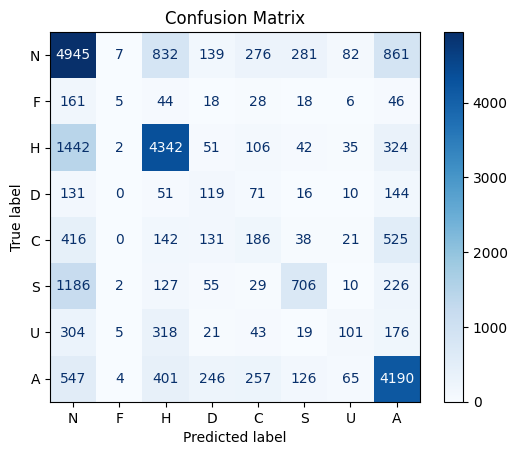

In [10]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(preds['EmoClass'], preds['Prediction'], labels=preds['EmoClass'].unique())

# Display labels
labels = preds['EmoClass'].unique()

# Visualize confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [11]:
preds_subset = get_stratified_subset(preds, 'EmoClass', 100)
preds_subset.head()

,Filename,Prediction,FileName,EmoClass,Gender,SpkrID
0,MSP-PODCAST_0653_0135.wav,N,MSP-PODCAST_0653_0135.wav,N,Female,210
1,MSP-PODCAST_2932_0307.wav,N,MSP-PODCAST_2932_0307.wav,N,Female,772
2,MSP-PODCAST_3131_0325.wav,N,MSP-PODCAST_3131_0325.wav,N,Male,2059
3,MSP-PODCAST_2295_0098.wav,N,MSP-PODCAST_2295_0098.wav,N,Female,1591
4,MSP-PODCAST_3813_1642_0001.wav,A,MSP-PODCAST_3813_1642_0001.wav,N,Male,1999


In [12]:
# Average F1-score using bootstrap
f1_scores = []
for i in range(100):
    preds_subset = get_stratified_subset(preds, 'EmoClass', 200, i)
    f1_scores.append(f1_score(preds_subset['EmoClass'], preds_subset['Prediction'], average='macro'))

In [13]:
f1_scores = np.array(f1_scores)

np.mean(f1_scores), np.std(f1_scores),np.max(f1_scores),np.min(f1_scores)

(0.3052819540764035,
 0.009018416807186258,
 0.3254405611531961,
 0.28625347760943076)

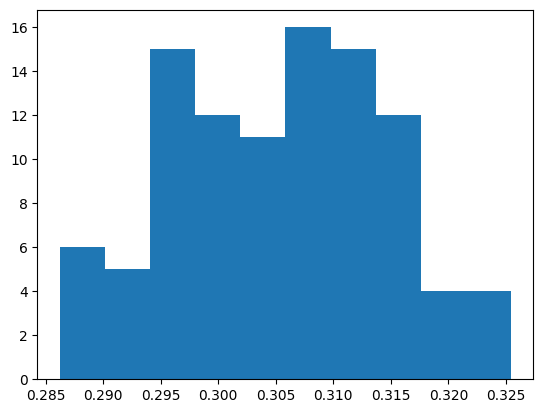

In [14]:
plt.hist(f1_scores, bins=10)
plt.show()

In [15]:
f1_score(preds['EmoClass'], preds['Prediction'], average='macro')

0.35917225554071514

In [16]:
f1_score(preds['EmoClass'], preds['Prediction'], average='micro')

0.5777971335814396

In [17]:
accuracy_score(preds['EmoClass'], preds['Prediction'])

0.5777971335814396

In [18]:
preds['PRED_dumb'] = 'N'
f1_score(preds['EmoClass'], preds['PRED_dumb'], average='macro'), accuracy_score(preds['EmoClass'], preds['PRED_dumb'])

(0.05678375814693552, 0.2938870852799113)

In [19]:
preds['EmoClass'].value_counts()

EmoClass
N    7423
H    6344
A    5836
S    2341
C    1459
U     987
D     542
F     326
Name: count, dtype: int64

In [20]:
preds.head(2)

,Filename,Prediction,FileName,EmoClass,Gender,SpkrID,PRED_dumb
0,MSP-PODCAST_0002_0033.wav,N,MSP-PODCAST_0002_0033.wav,N,Female,127,N
1,MSP-PODCAST_0002_0039.wav,N,MSP-PODCAST_0002_0039.wav,N,Female,127,N


In [21]:
f1_score(preds[preds['Gender']=='Female']['EmoClass'], preds[preds['Gender']=='Female']['Prediction'], average='macro')

0.3331764396650184

In [22]:
f1_score(preds[preds['Gender']=='Male']['EmoClass'], preds[preds['Gender']=='Male']['Prediction'], average='macro')

0.3799127369514858

In [23]:
accuracy_score(preds[preds['Gender']=='Female']['EmoClass'], preds[preds['Gender']=='Female']['Prediction'])

0.5207417823870627

In [24]:
accuracy_score(preds[preds['Gender']=='Male']['EmoClass'], preds[preds['Gender']=='Male']['Prediction'])

0.6245677233429395

In [25]:
for e in preds['EmoClass'].unique():
    acc = accuracy_score(preds[preds['EmoClass']==e]['EmoClass'], preds[preds['EmoClass']==e]['Prediction'])
    print(f'Emotion {e} acc = {acc}')

Emotion N acc = 0.6661727064529166
Emotion F acc = 0.015337423312883436
Emotion H acc = 0.6844262295081968
Emotion D acc = 0.21955719557195572
Emotion C acc = 0.12748457847840988
Emotion S acc = 0.30158052114480993
Emotion U acc = 0.10233029381965553
Emotion A acc = 0.7179575051405072


In [26]:
preds.groupby('SpkrID').agg({'Gender': 'count'}).reset_index().sort_values(by='Gender', ascending= False).head(10)

,SpkrID,Gender
17,210,3400
5,97,1371
610,2789,1135
4,54,444
281,2027,390
611,2794,353
623,2951,347
15,169,347
0,26,312
13,149,296


In [27]:
top10_volumetry_spks = preds.groupby('SpkrID').agg({'Gender': 'count'}).reset_index().sort_values(by='Gender', ascending= False).head(10).SpkrID

In [28]:
for spk in top10_volumetry_spks:
    emotions_spk = preds[preds['SpkrID']==spk]['EmoClass'].unique()
    gender = preds[preds['SpkrID']==spk]['Gender'].values[0]
    acc = accuracy_score(preds[preds['SpkrID']==spk]['EmoClass'], preds[preds['SpkrID']==spk]['Prediction'])
    f1_ = f1_score(preds[preds['SpkrID']==spk]['EmoClass'], preds[preds['SpkrID']==spk]['Prediction'], average='macro')
    print(f'Spk {spk} (Gender = {gender}) has emotions = {emotions_spk} with acc = {acc} f1-macro = {f1_}')

Spk 210 (Gender = Female) has emotions = ['F' 'S' 'N' 'D' 'C' 'A' 'U' 'H'] with acc = 0.3402941176470588 f1-macro = 0.2188188524174563
Spk 97 (Gender = Male) has emotions = ['H' 'C' 'N' 'D' 'U' 'A' 'F' 'S'] with acc = 0.49671772428884026 f1-macro = 0.2803059551490825
Spk 2789 (Gender = Male) has emotions = ['C' 'A' 'H' 'N' 'S' 'U' 'D'] with acc = 0.8185022026431719 f1-macro = 0.24616053404191227
Spk 54 (Gender = Male) has emotions = ['H' 'N' 'D' 'C' 'A' 'F' 'U'] with acc = 0.5112612612612613 f1-macro = 0.25668540880863533
Spk 2027 (Gender = Male) has emotions = ['A' 'C' 'N' 'H' 'S' 'U' 'D'] with acc = 0.6948717948717948 f1-macro = 0.28013293441010256
Spk 2794 (Gender = Male) has emotions = ['H' 'S' 'N' 'A' 'U'] with acc = 0.6997167138810199 f1-macro = 0.43505375172886124
Spk 2951 (Gender = Male) has emotions = ['H' 'N' 'A' 'S' 'C' 'U'] with acc = 0.8097982708933718 f1-macro = 0.37485596240035657
Spk 169 (Gender = Male) has emotions = ['H' 'N' 'C' 'A' 'U' 'S' 'D' 'F'] with acc = 0.47550

In [25]:
for spk in top10_volumetry_spks:
    df_filt = preds[preds['SpkrID']==spk]
    gender = df_filt.Gender.values[0]
    for e in df_filt['EmoClass'].unique():
        acc = accuracy_score(df_filt[df_filt['EmoClass']==e]['EmoClass'], df_filt[df_filt['EmoClass']==e]['Prediction'])
        print(f'SPK {spk} (gender = {gender}) in emotion {e} acc = {acc}')

SPK 210 (gender = Female) in emotion F acc = 0.03787878787878788
SPK 210 (gender = Female) in emotion S acc = 0.4251968503937008
SPK 210 (gender = Female) in emotion N acc = 0.10833333333333334
SPK 210 (gender = Female) in emotion D acc = 0.1744186046511628
SPK 210 (gender = Female) in emotion C acc = 0.07489878542510121
SPK 210 (gender = Female) in emotion A acc = 0.6967930029154519
SPK 210 (gender = Female) in emotion U acc = 0.13414634146341464
SPK 210 (gender = Female) in emotion H acc = 0.31891891891891894
SPK 97 (gender = Male) in emotion H acc = 0.7472727272727273
SPK 97 (gender = Male) in emotion C acc = 0.21367521367521367
SPK 97 (gender = Male) in emotion N acc = 0.14887640449438203
SPK 97 (gender = Male) in emotion D acc = 0.3466666666666667
SPK 97 (gender = Male) in emotion U acc = 0.2517985611510791
SPK 97 (gender = Male) in emotion A acc = 0.25274725274725274
SPK 97 (gender = Male) in emotion F acc = 0.19444444444444445
SPK 97 (gender = Male) in emotion S acc = 0.0
SPK 27

# Dimensional

In [26]:
!ls ../benchmark/model/dim_ser/7/results

dev.csv  test3.csv


In [27]:
preds = pd.read_csv('../benchmark/model/dim_ser/7/results/dev.csv')
preds.head()

,FileName,EmoAct,EmoVal,EmoDom
0,MSP-PODCAST_0002_0033.wav,4.110488,3.377474,4.107728
1,MSP-PODCAST_0002_0039.wav,4.309968,3.705411,4.469491
2,MSP-PODCAST_0002_0051.wav,3.757301,4.351225,4.176206
3,MSP-PODCAST_0002_0059.wav,4.127300,3.831695,4.195695
4,MSP-PODCAST_0002_0061.wav,4.053204,3.987261,4.183712


In [28]:
df = pd.read_csv('/workspace/lucas.ueda/interspeech_ser/data/Labels/labels_consensus.csv')
df.head(2)

,FileName,EmoClass,EmoAct,EmoVal,EmoDom,SpkrID,Gender,Split_Set
0,MSP-PODCAST_0002_0033.wav,N,4.8,4.2,5.4,127,Female,Development
1,MSP-PODCAST_0002_0039.wav,N,4.0,4.2,4.2,127,Female,Development


In [47]:
preds = preds.merge(df[['FileName','EmoAct','EmoVal','EmoDom']], how='left', on = 'FileName')

In [49]:
preds.head(2)

,FileName,EmoAct_x,EmoVal_x,EmoDom_x,EmoAct_y,EmoVal_y,EmoDom_y
0,MSP-PODCAST_0002_0033.wav,4.110488,3.377474,4.107728,4.8,4.2,5.4
1,MSP-PODCAST_0002_0039.wav,4.309968,3.705411,4.469491,4.0,4.2,4.2


In [48]:
import torch
def CCC_loss(pred, lab, m_lab=None, v_lab=None, is_numpy=True):
    """
    pred: (N, 3)
    lab: (N, 3)
    """
    if is_numpy:
        pred = torch.Tensor(pred).float()
        lab = torch.Tensor(lab).float()
    
    m_pred = torch.mean(pred, 0, keepdim=True)
    m_lab = torch.mean(lab, 0, keepdim=True)

    d_pred = pred - m_pred
    d_lab = lab - m_lab

    v_pred = torch.var(pred, 0, unbiased=False)
    v_lab = torch.var(lab, 0, unbiased=False)

    corr = torch.sum(d_pred * d_lab, 0) / (torch.sqrt(torch.sum(d_pred ** 2, 0)) * torch.sqrt(torch.sum(d_lab ** 2, 0)))

    s_pred = torch.std(pred, 0, unbiased=False)
    s_lab = torch.std(lab, 0, unbiased=False)

    ccc = (2*corr*s_pred*s_lab) / (v_pred + v_lab + (m_pred[0]-m_lab[0])**2)    
    return ccc

In [54]:
CCC_loss(preds[['EmoAct_x','EmoVal_x','EmoDom_x']].values,preds[['EmoAct_y','EmoVal_y','EmoDom_y']].values)

tensor([0.6949, 0.7050, 0.6312])

In [55]:
preds['EmoAct_d'] = preds['EmoAct_y'].mean() 
preds['EmoVal_d'] = preds['EmoVal_y'].mean() 
preds['EmoDom_d'] = preds['EmoDom_y'].mean() 

In [56]:
CCC_loss(preds[['EmoAct_d','EmoVal_d','EmoDom_d']].values,preds[['EmoAct_y','EmoVal_y','EmoDom_y']].values)

tensor([-0., -0., -0.])